In [135]:
import chess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
from sklearn.linear_model import LinearRegression

from p4_generate_dataset import SAMPLE_ELOS

In [136]:
df = pd.read_parquet("../data/stats_dataset.parquet")
df.head()

,fen,next_move,played_by_elo,win_pov,engine_move,fragility_score,delta,variance,score_base,winrate_500,...,historical_best_2200,score_2200,recommended_move_2200,is_best_2200,is_engine_best_2200,frag_rec_2200,is_frag_best_2200,mix_score_2200,mix_rec_2200,is_mix_best_2200
0,r1b1kb1r/ppp1pppp/2n1qn2/8/8/2N2N2/PPPPBPPP/R1...,d2d4,1296.660714,0.625000,d2d4,1.000000,0.435936,0.667668,0.701201,0.602151,...,d2d4,0.701201,d2d4,True,True,e1g1,False,0.435936,d2d4,True
1,r1b1kb1r/ppp1pppp/2n1qn2/8/8/2N2N2/PPPPBPPP/R1...,e1g1,1317.025455,0.603636,d2d4,1.000000,0.101101,0.256757,0.452619,0.604651,...,d2d4,0.452619,d2d4,True,True,e1g1,False,0.101101,d2d4,True
2,r1b1kbnr/ppp1pppp/2n1Q3/8/8/2N5/PPPP1PPP/R1B1K...,c8e6,1417.240803,0.484950,c8e6,0.705706,0.550050,0.189189,0.481648,0.479042,...,c8e6,0.481648,c8e6,True,True,c8e6,True,0.550050,c8e6,True
3,r1b1kbnr/ppp1pppp/2n1q3/8/8/2N2N2/PPPPBPPP/R1B...,c8d7,1391.673540,0.398625,e6d7,0.967968,0.026527,0.706206,0.566900,0.419689,...,e6g6,0.566900,e6g6,True,False,c8d7,False,0.026527,g8f6,False
4,r1b1kbnr/ppp1pppp/2n1q3/8/8/2N2N2/PPPPBPPP/R1B...,e6g6,1505.278317,0.543689,e6d7,0.967968,0.007007,0.958959,0.644645,0.517483,...,e6g6,0.644645,e6g6,True,False,c8d7,False,0.007007,g8f6,False


In [137]:
df.describe()

,played_by_elo,win_pov,fragility_score,delta,variance,score_base,winrate_500,score_500,mix_score_500,winrate_850,...,mix_score_850,winrate_1200,score_1200,mix_score_1200,winrate_1500,score_1500,mix_score_1500,winrate_2200,score_2200,mix_score_2200
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,...,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,1526.199247,0.477667,0.710333,0.385730,0.492973,0.529679,0.476472,0.529679,0.548031,0.477835,...,0.548031,0.477458,0.529679,0.515571,0.477588,0.529679,0.466881,0.478601,0.529679,0.385730
std,177.868277,0.071875,0.282129,0.267884,0.332720,0.175741,0.090686,0.175741,0.217945,0.074764,...,0.217945,0.071673,0.175741,0.218732,0.071913,0.175741,0.229317,0.073906,0.175741,0.267884
min,1153.491870,0.216138,0.000000,0.000000,0.000000,0.039706,0.208754,0.039706,0.001502,0.217391,...,0.001502,0.216138,0.039706,0.001802,0.216138,0.039706,0.002252,0.171429,0.039706,0.000000
25%,1389.824050,0.435593,0.632382,0.105105,0.156281,0.411241,0.422571,0.411241,0.439377,0.430927,...,0.439377,0.433866,0.411241,0.373444,0.435593,0.411241,0.274431,0.435819,0.411241,0.105105
50%,1502.594541,0.478714,0.758988,0.450895,0.578653,0.546392,0.474984,0.546392,0.577327,0.475569,...,0.577327,0.479940,0.546392,0.555956,0.478714,0.546392,0.518318,0.480970,0.546392,0.450895
75%,1676.579927,0.514128,0.936998,0.533534,0.702578,0.646820,0.529926,0.646820,0.708208,0.518264,...,0.708208,0.513946,0.646820,0.658710,0.514095,0.646820,0.596565,0.513535,0.646820,0.533534
max,1894.221239,0.922414,1.000000,1.000000,1.000000,0.951451,0.914286,0.951451,0.986236,0.921053,...,0.986236,0.922414,0.951451,0.988188,0.922414,0.951451,0.991116,0.960000,0.951451,1.000000


In [138]:
results = []

for elo in SAMPLE_ELOS:
    is_best_col = f"is_best_{elo}"
    is_engine_col = f"is_engine_best_{elo}"
    is_frag_col = f"is_frag_best_{elo}"
    is_mix_col = f"is_mix_best_{elo}"

    avg_is_best = df[is_best_col].mean()
    avg_is_engine_best = df[is_engine_col].mean()
    avg_is_frag_best = df[is_frag_col].mean()
    avg_is_mix_best = df[is_mix_col].mean()

    results.append({
        "elo": elo,
        "avg_is_best": avg_is_best,
        "avg_is_engine_best": avg_is_engine_best,
        "avg_is_frag_best": avg_is_frag_best,
        "avg_is_mix_best": avg_is_mix_best
    })

pd.DataFrame(results)

,elo,avg_is_best,avg_is_engine_best,avg_is_frag_best,avg_is_mix_best
0,500,0.492188,0.312500,0.507812,0.503906
1,850,0.554688,0.417969,0.503906,0.589844
2,1200,0.574219,0.410156,0.468750,0.566406
3,1500,0.574219,0.425781,0.484375,0.566406
4,2200,0.566406,0.437500,0.492188,0.585938


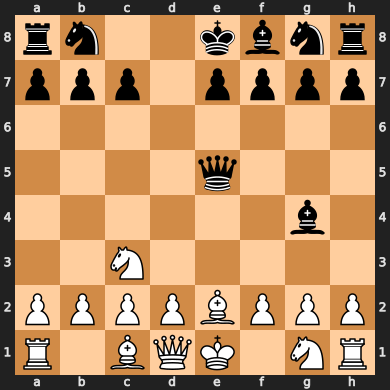

In [139]:
random_fen = df["fen"].sample(1).iloc[0]
filtered = df[df["fen"] == random_fen]
chess.Board(random_fen)

In [140]:
filtered

,fen,next_move,played_by_elo,win_pov,engine_move,fragility_score,delta,variance,score_base,winrate_500,...,historical_best_2200,score_2200,recommended_move_2200,is_best_2200,is_engine_best_2200,frag_rec_2200,is_frag_best_2200,mix_score_2200,mix_rec_2200,is_mix_best_2200
59,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,d2d4,1664.383057,0.532228,d2d4,0.858358,1.000000,0.983483,0.947281,0.578616,...,d2d4,0.947281,d2d4,True,True,g1f3,False,1.000000,d2d4,True
60,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,f2f3,1465.225000,0.519231,d2d4,0.858358,0.441441,0.234234,0.511345,0.538462,...,d2d4,0.511345,d2d4,True,True,g1f3,False,0.441441,d2d4,True
61,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,g1f3,1451.173116,0.435845,d2d4,0.858358,0.008509,0.987487,0.618118,0.492000,...,d2d4,0.618118,d2d4,True,True,g1f3,False,0.008509,d2d4,True
62,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,h2h3,1498.648780,0.463415,d2d4,0.858358,0.090591,0.943605,0.630851,0.490000,...,d2d4,0.630851,d2d4,True,True,g1f3,False,0.090591,d2d4,True


# Regression Analysis

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 64 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fen                    256 non-null    object 
 1   next_move              256 non-null    object 
 2   played_by_elo          256 non-null    float64
 3   win_pov                256 non-null    float64
 4   engine_move            256 non-null    object 
 5   fragility_score        256 non-null    float64
 6   delta                  256 non-null    float64
 7   variance               256 non-null    float64
 8   score_base             256 non-null    float64
 9   winrate_500            256 non-null    float64
 10  historical_best_500    256 non-null    object 
 11  score_500              256 non-null    float64
 12  recommended_move_500   256 non-null    object 
 13  is_best_500            256 non-null    bool   
 14  is_engine_best_500     256 non-null    bool   
 15  frag_r

In [142]:
# df["f_cross_d"] = df["fragility_score"] * df["delta"]
# df["f_cross_v"] = df["fragility_score"] * df["variance"]
# df["d_cross_v"] = df["delta"] * df["variance"]

selected_features = ["fragility_score", "delta", "variance", "score_base"] #"f_cross_d", "f_cross_v", "d_cross_v", ]
X = df[selected_features]
y = df["is_best_1500"]

In [143]:
model = LinearRegression()
model.fit(X, y)

for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.3f}")

fragility_score: 0.022
delta: 0.364
variance: 0.104
score_base: 0.163


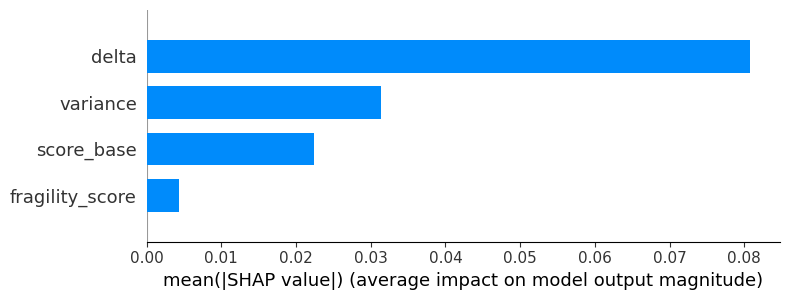

In [144]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, plot_type="bar")

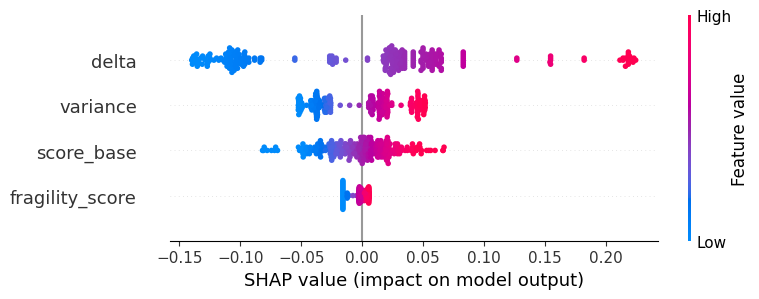

In [145]:
shap.summary_plot(shap_values, X, show=True)

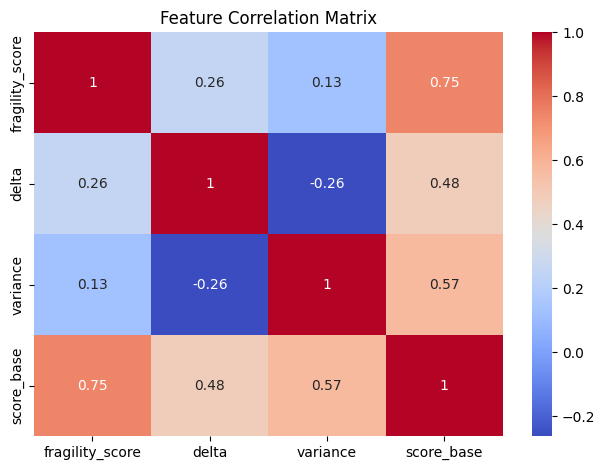

In [146]:
sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()